In [3]:
 import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, r2_score, mean_absolute_error, mean_squared_error, silhouette_score
import random
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError as ann_mse
from tensorflow.keras import optimizers
import missingno as msno
from scipy.stats import spearmanr
def regr(estimator, x, y, label):
    y_pred = estimator.predict(x)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    met_df = pd.DataFrame({'r2':r2,
             'mse':mse,
             'rmse':rmse,
             'mae':mae}, index = [label])
    return(met_df)

def merg(a):
    b = pd.DataFrame()
    for x in a:
        b = pd.concat([b,x], axis=0)
    print(b)

In [4]:
df = pd.read_csv('/content/Boston.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [5]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) # split data test and data train into 40% of data test 
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42) # split data test and data valid into 50% each 

In [7]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(303, 12) (102, 12) (101, 12)
(303,) (102,) (101,)


In [8]:
rs = RobustScaler()
X_train_scl = pd.DataFrame(rs.fit_transform(X_train), columns = X_train.columns)
X_test_scl = pd.DataFrame(rs.transform(X_test), columns=X_test.columns)
X_valid_scl = pd.DataFrame(rs.transform(X_valid), columns= X_valid.columns)

## Build Neural Network 2 Hidden Layer 

In [9]:
# BUILD NN WITH 2 HIDDEN LAYERS 

backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model = Sequential() 
model.add(Dense(32, input_shape = (X_train_scl.shape[1],)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1))

learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate)
model.compile(loss= ann_mse(), optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

## Test model before training to see how good the model withut training 

In [10]:
example = X_train_scl[:10]
result = model.predict(example)
result

array([[ 0.00936684],
       [-0.0257154 ],
       [-0.03661841],
       [ 0.19043808],
       [ 0.17004043],
       [ 0.2236911 ],
       [ 0.04681667],
       [-0.14445204],
       [-0.04891448],
       [ 0.8438736 ]], dtype=float32)

In [11]:
y_train[:10]

304    36.1
83     22.9
248    24.5
165    25.0
163    50.0
199    34.9
231    31.7
74     24.1
311    22.1
455    14.1
Name: MEDV, dtype: float64

## Training models above 

In [12]:
%%time 
num_epoch = 500
batch_size = 32 
model.summary()

history = model.fit(X_train_scl, y_train, batch_size= batch_size, 
                    epochs = num_epoch, verbose = 1, shuffle = True, 
                    validation_data = (X_valid_scl, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [13]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,mae,mse,mape,val_loss,val_mae,val_mse,val_mape,epoch
495,15.772382,2.909214,15.772382,14.969991,14.423432,2.497535,14.423432,13.677008,495
496,14.021386,2.718545,14.021386,13.724877,14.237928,2.394756,14.237928,13.366836,496
497,13.123939,2.707044,13.123939,13.660806,14.301285,2.401446,14.301285,13.307198,497
498,14.559734,2.858735,14.559734,14.191049,14.282474,2.418581,14.282474,13.267601,498
499,15.242049,2.858685,15.242049,13.985803,14.305548,2.462653,14.305548,13.453955,499


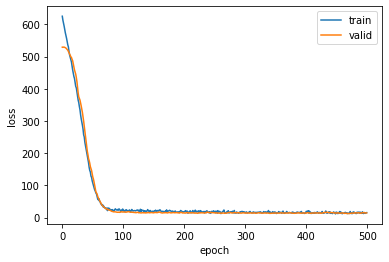

In [14]:
sns.lineplot(data=history_df, x='epoch', y='loss', label='train')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='valid')
plt.show()

In [15]:
epoch= history_df['epoch'].values
valid = history_df['val_loss'].values
epoch[np.argmin(valid)]
np.sqrt(valid[134])

3.859958372929308

In [16]:
example = X_train_scl[:10]
result = model.predict(example)
result

array([[33.320347],
       [21.7039  ],
       [21.660131],
       [22.12803 ],
       [50.863514],
       [30.029776],
       [31.56449 ],
       [24.173565],
       [23.547903],
       [16.730774]], dtype=float32)

In [17]:
merg([regr(model, X_train_scl, y_train, 'train'),
     regr(model, X_test_scl, y_test, 'test')])

             r2       mse      rmse       mae
train  0.929126  6.323826  2.514722  1.887835
test   0.870767  8.499143  2.915329  2.135537


## Build Neural Network with 3 Hidden Layer

In [18]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model = Sequential() 
model.add(Dense(32, input_shape = (X_train_scl.shape[1],)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1))

learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate)
model.compile(loss= ann_mse(), optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [19]:
%%time 
num_epoch = 500
batch_size = 32 
model.summary()

history = model.fit(X_train_scl, y_train, batch_size= batch_size, 
                    epochs = num_epoch, verbose = 1, shuffle = True, 
                    validation_data = (X_valid_scl, y_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [20]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,mae,mse,mape,val_loss,val_mae,val_mse,val_mape,epoch
495,15.852240,3.042008,15.852240,16.080355,12.994807,2.493907,12.994807,14.151805,495
496,15.109003,2.966259,15.109003,15.102710,12.738085,2.465905,12.738085,14.163047,496
497,14.980240,2.862900,14.980240,14.995110,13.094097,2.486907,13.094097,14.146061,497
498,16.296831,2.918651,16.296831,14.799141,13.543200,2.557137,13.543200,14.449417,498
499,14.994666,2.911378,14.994666,14.805677,13.491679,2.596245,13.491679,14.628814,499


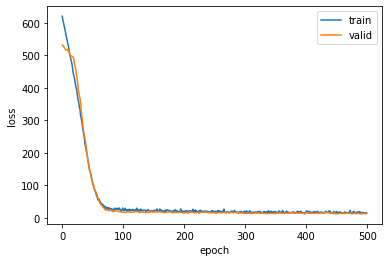

In [21]:
sns.lineplot(data=history_df, x='epoch', y='loss', label='train')
sns.lineplot(data=history_df, x='epoch', y='val_loss', label='valid')
plt.show()

In [22]:
epoch= history_df['epoch'].values
valid = history_df['val_loss'].values
epoch[np.argmin(valid)]
np.sqrt(valid[134])

4.1128715463247065

In [23]:
merg([regr(model, X_train_scl, y_train, 'train'),
     regr(model, X_test_scl, y_test, 'test')])

             r2       mse      rmse       mae
train  0.912543  7.803491  2.793473  2.103723
test   0.858286  9.319939  3.052857  2.142171
